# Gender Distribution of PGP Particpants

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import pandas as pd
import numpy as np
import os as os
from datetime import datetime
from datetime import date
import sqlite3

In [53]:
# Set default plot stype for matplotlib
plt.style.use('ggplot')

# Set default figure size for matplotlib
plt.rcParams['figure.figsize'] = (16, 8)

In [54]:
# Connect to untap database, found here: 
#https://workbench.su92l.arvadosapi.com/collections/22d61dd43786c65cd175b04ad6954af0+3119/html/index.html#

conn = sqlite3.connect('Database/untap.db')
c = conn.cursor()
c.execute('SELECT * FROM survey')
rows = c.fetchall()
pgpdataS = pd.DataFrame(rows,columns=zip(*c.description)[0])
conn.close()

conn = sqlite3.connect('Database/untap.db')
c = conn.cursor()
c.execute('SELECT * FROM enrollment_date')
rows = c.fetchall()
pgpdataE = pd.DataFrame(rows,columns=zip(*c.description)[0])
conn.close()

In [55]:
# Extract genders from survery results
idx = pgpdataS.phenotype_category == 'Participant_Survey:Sex/Gender'
pgpdataG = pgpdataS[idx]

In [56]:
# Merge enrollment data and gender data based on human id

pgpdataTotal = pgpdataE.merge(pgpdataG, on='human_id', how='inner')

In [57]:
# Count participants by gender

pgpdataTotal.phenotype = pgpdataTotal.phenotype.str.lower() 
genderTotals = pgpdataTotal.groupby('phenotype')['human_id'].count()
genderTotals

phenotype
agender              1
female            1464
genderqueer          5
male              1979
neutrois             1
no response         10
non binary           1
nonbinary            1
transmasculine       1
Name: human_id, dtype: int64

In [58]:
# Count people enrollement by date, need to convert data from string to datetime first

pgpEnrollbyGender = pd.crosstab(pgpdataTotal['enrollment_date'],pgpdataTotal.phenotype)
pgpEnrollbyGender.index = pd.to_datetime(pgpEnrollbyGender.index,format='%Y-%m-%dT%H:%M:%SZ')

# Sort date from earliest to latest
pgpEnrollbyGender = pgpEnrollbyGender.sort_index()

In [59]:
# Resample enrollment to have enrollment at constant intervals , year and month
pgpEnrollbyGenderRSY = pgpEnrollbyGender.resample('A',how = 'sum')
pgpEnrollbyGenderRSY.fillna(0);

pgpEnrollbyGenderRSM = pgpEnrollbyGender.resample('M',how = 'sum')
pgpEnrollbyGenderRSM.fillna(0);

In [60]:
pgpEnrollbyGenderRSY2 = pgpEnrollbyGenderRSY.loc[:,{'male','female'}]
OtherY = pgpEnrollbyGenderRSY.loc[:,{'agender','genderqueer','neutrois','non binary','transmasculine'}]
pgpEnrollbyGenderRSY2['other'] = OtherY.sum(axis=1)

pgpEnrollbyGenderRSM2 = pgpEnrollbyGenderRSM.loc[:,{'male','female'}]
OtherM = pgpEnrollbyGenderRSM.loc[:,{'agender','genderqueer','neutrois','non binary','transmasculine'}]
pgpEnrollbyGenderRSM2['other'] = OtherM.sum(axis=1)

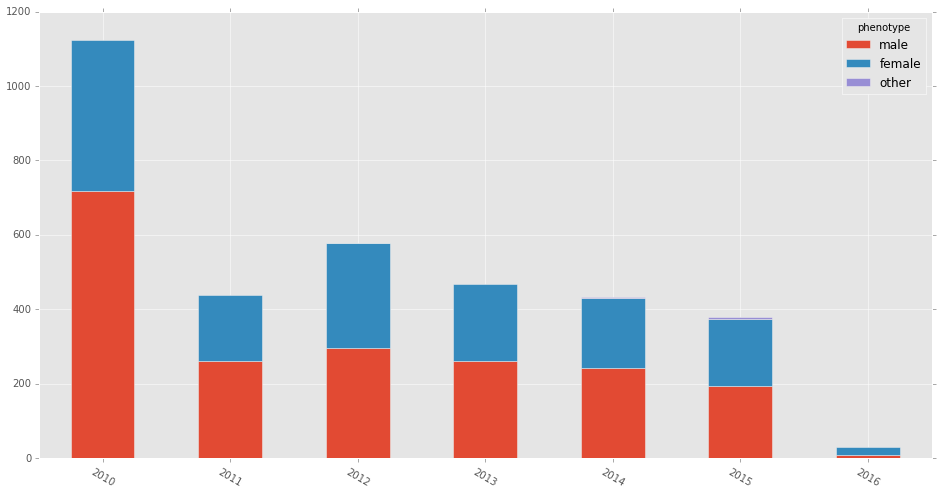

In [61]:
# Plot enrollment by year

ax = pgpEnrollbyGenderRSY2.plot(kind='bar',stacked=True)
formatted_ticks = pgpEnrollbyGenderRSY2.index.map(lambda t: t.strftime('%Y'))
tick_labels = ax.set_xticklabels(formatted_ticks,rotation=330,fontsize = 10)

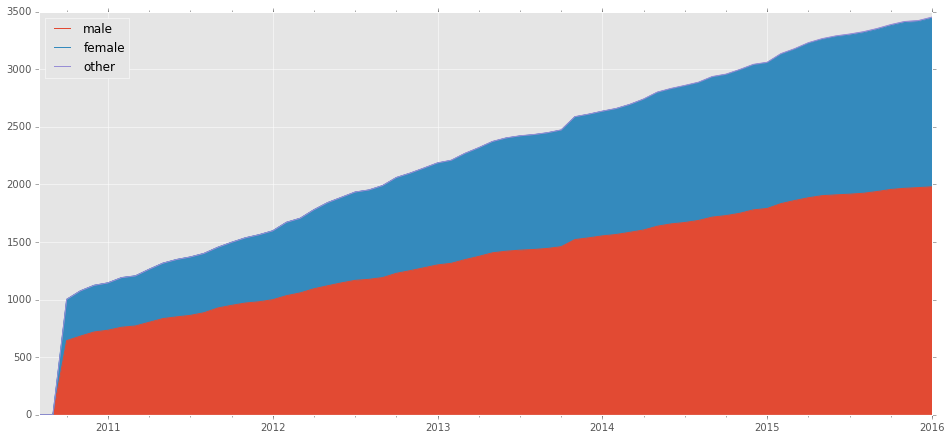

In [62]:
# Calculate and plot total participants by month

totalpgpEnrollbyGender2 = pd.expanding_sum(pgpEnrollbyGenderRSM2)

h2 = totalpgpEnrollbyGender2.plot(kind='area',stacked=True)
h2.legend(loc = 'upper left', fontsize = 12)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('Images/GenderEnrollment.svg')